In [4]:
#1. Significant earthquakes since 2150 B.C.
import pandas as pd

# 读取 TSV 文件，处理编码和错误行
file_path = r"D:\code\earthquakes-2025-11-05_21-17-35_+0800.tsv"
Sig_Eqs = pd.read_csv(file_path, sep='\t', encoding='utf-8', on_bad_lines='skip', low_memory=False)



In [5]:
# 将 Deaths 列转换为数值，处理缺失值
Sig_Eqs['Deaths'] = pd.to_numeric(Sig_Eqs['Deaths'], errors='coerce').fillna(0)

# 按国家汇总死亡人数
deaths_by_country = Sig_Eqs.groupby('Country')['Deaths'].sum().sort_values(ascending=False)

# 打印前十名
print("Top 10 countries by total earthquake deaths:")
print(deaths_by_country.head(10))


Top 10 countries by total earthquake deaths:
Country
CHINA         2139210.0
TURKEY        1199742.0
IRAN          1014453.0
ITALY          498219.0
SYRIA          419226.0
HAITI          323484.0
AZERBAIJAN     319251.0
JAPAN          242445.0
ARMENIA        191890.0
PAKISTAN       145083.0
Name: Deaths, dtype: float64


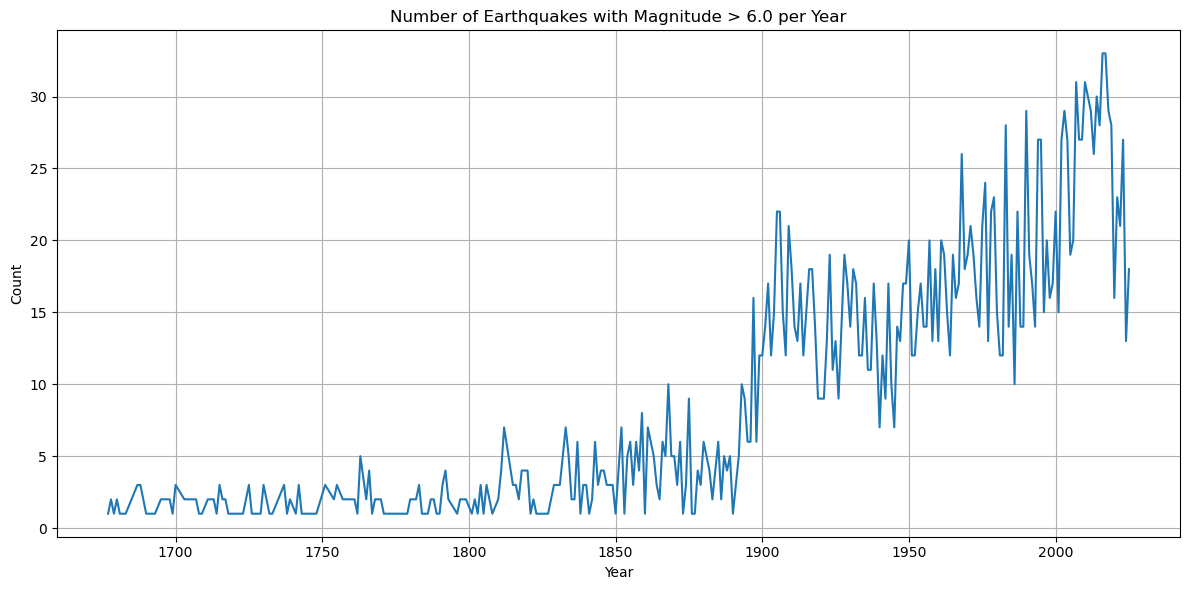

In [6]:
Sig_Eqs['Mag'] = pd.to_numeric(Sig_Eqs['Mag'], errors='coerce')

# 构造日期列（如上）
Sig_Eqs['Year'] = pd.to_numeric(Sig_Eqs['Year'], errors='coerce')
Sig_Eqs['Mo'] = pd.to_numeric(Sig_Eqs['Mo'], errors='coerce')
Sig_Eqs['Dy'] = pd.to_numeric(Sig_Eqs['Dy'], errors='coerce')
Sig_Eqs['Date'] = pd.to_datetime(dict(year=Sig_Eqs['Year'], month=Sig_Eqs['Mo'], day=Sig_Eqs['Dy']), errors='coerce')

# 筛选震级 > 6.0 的地震
high_mag_eqs = Sig_Eqs[Sig_Eqs['Mag'] > 6.0].copy()

# 按年份统计数量
high_mag_eqs['Year'] = high_mag_eqs['Date'].dt.year
eqs_per_year = high_mag_eqs.groupby('Year').size()

# 绘图
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
eqs_per_year.plot()
plt.title("Number of Earthquakes with Magnitude > 6.0 per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()



In [7]:
def CountEq_LargestEq(country):
    df_country = Sig_Eqs[Sig_Eqs['Country'] == country].copy()
    total_eqs = len(df_country)
    
    # 处理 Mag 和 Date 列
    df_country['Mag'] = pd.to_numeric(df_country['Mag'], errors='coerce')
    df_country['Date'] = pd.to_datetime(df_country['Date'], errors='coerce')
    
    # 找出最大震级对应的日期
    if df_country['Mag'].isna().all():
        largest_eq_date = None
    else:
        max_mag_idx = df_country['Mag'].idxmax()
        largest_eq_date = df_country.loc[max_mag_idx, 'Date']
    
    return total_eqs, largest_eq_date

# 应用于所有国家
results = []
for country in Sig_Eqs['Country'].dropna().unique():
    total, date = CountEq_LargestEq(country)
    results.append((country, total, date))

# 按地震数量排序
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

# 打印结果
print("Earthquake count and largest magnitude date by country:")
for country, total, date in results_sorted:
    print(f"{country}: {total} earthquakes, largest on {date}")


Earthquake count and largest magnitude date by country:
CHINA: 623 earthquakes, largest on NaT
JAPAN: 424 earthquakes, largest on 2011-03-11 00:00:00
INDONESIA: 421 earthquakes, largest on 2004-12-26 00:00:00
IRAN: 388 earthquakes, largest on NaT
TURKEY: 358 earthquakes, largest on 1939-12-26 00:00:00
ITALY: 333 earthquakes, largest on 1915-01-13 00:00:00
GREECE: 289 earthquakes, largest on NaT
USA: 280 earthquakes, largest on 1964-03-28 00:00:00
PHILIPPINES: 230 earthquakes, largest on 1897-09-21 00:00:00
MEXICO: 214 earthquakes, largest on 1787-03-28 00:00:00
CHILE: 200 earthquakes, largest on 1960-05-22 00:00:00
PERU: 194 earthquakes, largest on 1716-02-06 00:00:00
RUSSIA: 158 earthquakes, largest on 1952-11-04 00:00:00
PAPUA NEW GUINEA: 107 earthquakes, largest on 1919-05-06 00:00:00
INDIA: 102 earthquakes, largest on 1950-08-15 00:00:00
TAIWAN: 101 earthquakes, largest on 1920-06-05 00:00:00
COLOMBIA: 82 earthquakes, largest on 1826-06-18 00:00:00
NEW ZEALAND: 72 earthquakes, larg

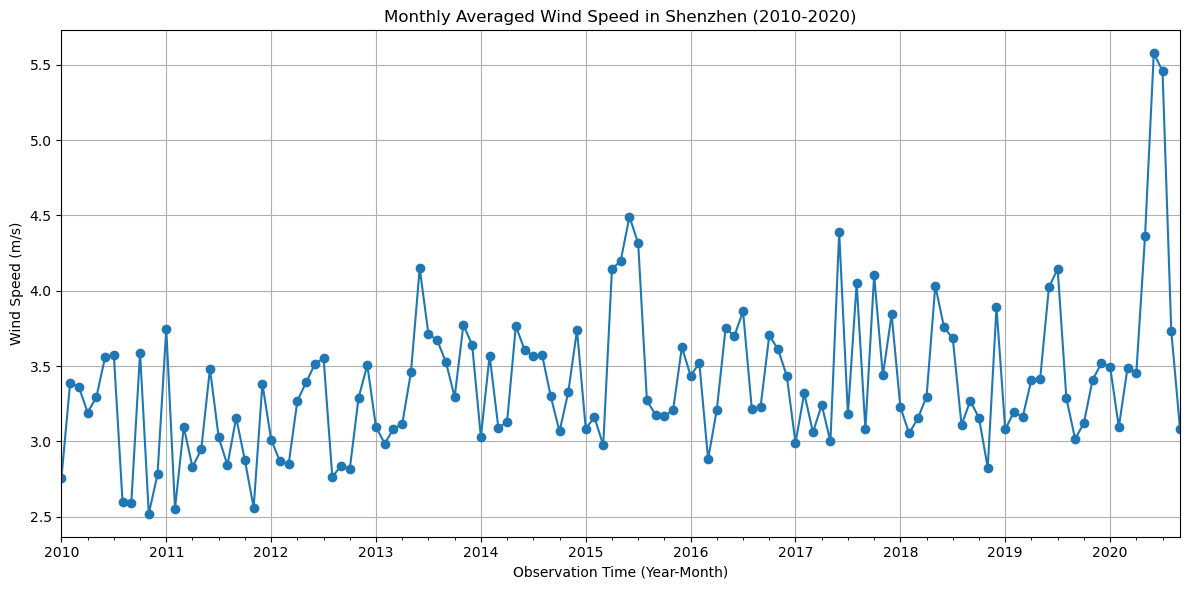

趋势斜率: 0.0002 m/s per day, p值=0.0000
结论：风速有显著上升趋势


In [29]:
#2. Wind speed in Shenzhen from 2010 to 2020
import pandas as pd
import matplotlib.pyplot as plt

# 1. 读取数据
file_path = r"D:\code\2281305.csv"

# NOAA ISD 数据通常是定长格式，但这里是 CSV，需参考用户手册 POS 61-70
# 假设风速字段在 "WND" 或类似列中，单位是米/秒
# 如果列名不同，请用 df.head() 查看后修改
df = pd.read_csv(file_path, low_memory=False)

# 2. 时间字段处理
# NOAA ISD 通常有 "DATE" 或 "YEARMODAHRMN" 字段，格式如 YYYYMMDDHHMM
# 这里假设有 "DATE" 列，若不同请替换
if "DATE" in df.columns:
    df["DATE"] = pd.to_datetime(df["DATE"], errors="coerce")
elif "YEARMODAHRMN" in df.columns:
    df["DATE"] = pd.to_datetime(df["YEARMODAHRMN"], format="%Y%m%d%H%M", errors="coerce")

# 3. 风速字段处理
# POS 65-70 对应风速，通常在 "WND" 列，格式如 "ddd,dd,dd,dd"
# 这里假设有 "WND" 列，提取风速值（米/秒）
def parse_wind(wnd_str):
    try:
        # NOAA WND 格式: "ddd,dd,dd,dd" → 第三位是风速
        parts = str(wnd_str).split(",")
        if len(parts) >= 4 and parts[3] != "9999":
            return float(parts[3]) / 10.0  # 单位通常是 m/s *10
    except:
        return None
    return None

if "WND" in df.columns:
    df["WIND_SPEED"] = df["WND"].apply(parse_wind)
else:
    # 如果已经有风速列，比如 "wind_speed"
    df["WIND_SPEED"] = pd.to_numeric(df["wind_speed"], errors="coerce")

# 4. 按月平均
df = df.dropna(subset=["DATE", "WIND_SPEED"])
df["YEAR_MONTH"] = df["DATE"].dt.to_period("M")
monthly_avg = df.groupby("YEAR_MONTH")["WIND_SPEED"].mean()

# 5. 绘图
plt.figure(figsize=(12,6))
monthly_avg.plot(marker="o", linestyle="-")
plt.title("Monthly Averaged Wind Speed in Shenzhen (2010-2020)")
plt.xlabel("Observation Time (Year-Month)")
plt.ylabel("Wind Speed (m/s)")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6. 趋势判断（简单线性回归）
from scipy.stats import linregress

x = monthly_avg.index.to_timestamp()
x_num = (x - x.min()).days  # 转换为数值
slope, intercept, r_value, p_value, std_err = linregress(x_num, monthly_avg.values)

print(f"趋势斜率: {slope:.4f} m/s per day, p值={p_value:.4f}")
if p_value < 0.05:
    if slope > 0:
        print("结论：风速有显著上升趋势")
    else:
        print("结论：风速有显著下降趋势")
else:
    print("结论：风速没有显著趋势")


In [7]:
#3. Explore a data set

import pandas as pd

file_path = r"D:\code\全国主要城市空气质量.csv"

# 尝试使用 GBK 编码读取
df = pd.read_csv(file_path, encoding='gbk', on_bad_lines='skip')

# 显示前几行和列名，确认读取成功
print(df.head())
print(df.columns)



# 删除缺失值或质量差的数据（例如 AQI 为 NaN 或负值）
df.columns = df.columns.str.strip()
df_clean = df.dropna()
df_clean = df_clean[df_clean['AQI指数'] >= 0]  # 假设 AQI 是你关注的变量


   城市        日期 质量等级  AQI指数   当天AQI排名  PM2.5  PM10  So2  No2    Co  O3
0  北京  2022/3/1    优      25        9      6    17    2   10  0.25  68
1  北京  2022/3/2    优      43       52     16    44    2   25  0.40  49
2  北京  2022/3/3    良      57       98     24    68    4   26  0.56  53
3  北京  2022/3/4    良      72      158     27    97    2   24  0.47  54
4  北京  2022/3/5    优      32       25      7    31    2   10  0.23  66
Index(['城市', '日期', '质量等级', 'AQI指数 ', '当天AQI排名', 'PM2.5', 'PM10', 'So2', 'No2',
       'Co', 'O3'],
      dtype='object')


C:\Users\45527\AppData\Local\Temp\ipykernel_293256\1673751191.py:18: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\45527\AppData\Local\Temp\ipykernel_293256\1673751191.py:18: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\45527\AppData\Local\Temp\ipykernel_293256\1673751191.py:18: UserWarning: Glyph 25351 (\N{CJK UNIFIED IDEOGRAPH-6307}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\45527\AppData\Local\Temp\ipykernel_293256\1673751191.py:18: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\45527\AppData\Local\Temp\ipykernel_293256\1673751191.py:18: UserWarning: Glyph 20840 (\N{CJK UNIFIED IDEOGRAPH-5168}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\45527\AppData\Local\Temp\ipykernel_293256\1673751191.py:18: UserWarning: Glyph 22

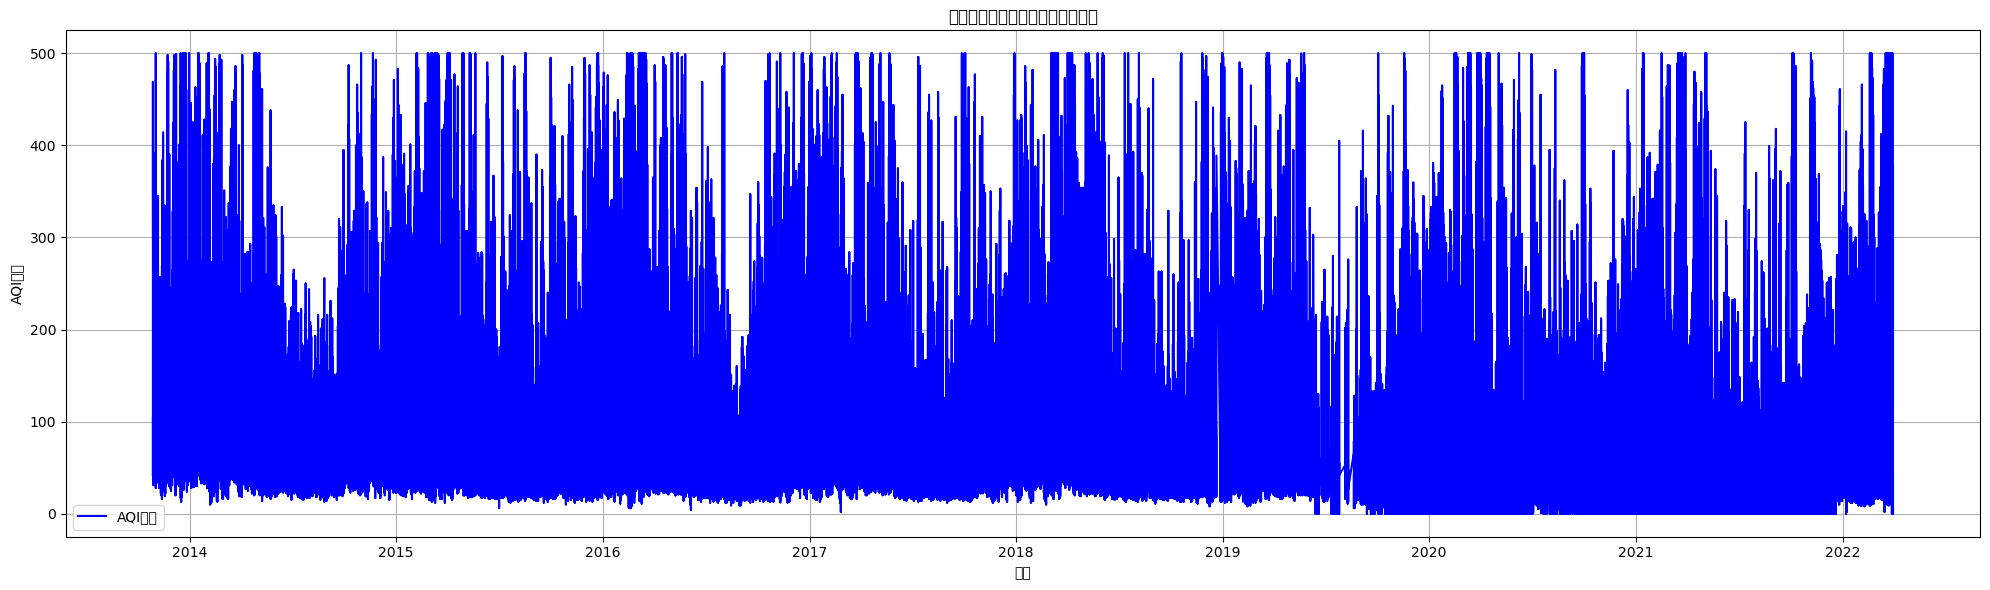

In [11]:
import matplotlib.pyplot as plt

# 假设有一个时间列叫做 '日期'，先转换为 datetime 类型
df_clean['日期'] = pd.to_datetime(df_clean['日期'], errors='coerce')
df_clean = df_clean.dropna(subset=['日期'])  # 删除无法解析的日期

# 按日期排序
df_clean = df_clean.sort_values('日期')

# 绘制 AQI 的时间序列图
plt.figure(figsize=(12, 6))
plt.plot(df_clean['日期'], df_clean['AQI指数'], label='AQI指数', color='blue')
plt.xlabel('日期')
plt.ylabel('AQI指数')
plt.title('全国主要城市空气质量时间序列图')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# 统计分析
print("AQI指数 的基本统计信息：")
print(df_clean['AQI指数'].describe())

# 其他统计检查
print("最大值：", df_clean['AQI指数'].max())
print("最小值：", df_clean['AQI指数'].min())
print("中位数：", df_clean['AQI指数'].median())
print("标准差：", df_clean['AQI指数'].std())
print("是否有异常值（AQI指数 > 500）：", (df_clean['AQI指数'] > 500).sum())


AQI指数 的基本统计信息：
count    974449.000000
mean         70.868673
std          46.885637
min           0.000000
25%          42.000000
50%          60.000000
75%          84.000000
max         500.000000
Name: AQI指数, dtype: float64
最大值： 500
最小值： 0
中位数： 60.0
标准差： 46.88563718814081
是否有异常值（AQI指数 > 500）： 0
